In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

c:\Users\waiho\Documents\Python_venv\AI_ML_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
totensor = transforms.Compose(
  [transforms.ToTensor()])

batch_size = 32

trainval_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=totensor)
train_set, val_set = torch.utils.data.random_split(trainval_set, [int(0.8*len(trainval_set)), int(0.2*len(trainval_set))])

test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=totensor)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
print(len(train_set), len(val_set), len(test_set))

40000 10000 10000


In [4]:
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

In [5]:
print("First data point")
print(f"Shape: {train_set[0][0].size()}")
print(f"Tensor: {train_set[0][0]}")
print(f"Label: {train_set[0][1]}")

First data point
Shape: torch.Size([3, 32, 32])
Tensor: tensor([[[1.0000, 1.0000, 1.0000,  ..., 0.8510, 0.9333, 1.0000],
         [0.9922, 0.9922, 0.9922,  ..., 0.7176, 0.8863, 0.9843],
         [0.9922, 0.9922, 0.9922,  ..., 1.0000, 1.0000, 0.9922],
         ...,
         [0.9922, 0.9922, 0.9922,  ..., 0.9922, 0.9922, 0.9922],
         [0.9922, 0.9922, 0.9922,  ..., 0.9922, 0.9922, 0.9922],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 0.8510, 0.9373, 1.0000],
         [0.9922, 0.9922, 0.9922,  ..., 0.7176, 0.8902, 0.9882],
         [0.9922, 0.9922, 0.9922,  ..., 1.0000, 1.0000, 0.9922],
         ...,
         [0.9922, 0.9922, 0.9922,  ..., 0.9922, 0.9922, 0.9922],
         [0.9922, 0.9922, 0.9922,  ..., 0.9922, 0.9922, 0.9922],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 0.8431, 0.9294, 0.9961],
         [0.9922, 0.9922, 0.9922,  ..., 0.7098, 0.8824, 0.9843],
  

In [6]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [7]:
torch.zeros(1).cuda()

tensor([0.], device='cuda:0')

In [8]:
data_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=(-5, 5)),
    transforms.ColorJitter(brightness=(0.6,1.4), contrast=(0.6,1.4), saturation=(0.6,1.4), hue=(-0.1,0.1))
])

In [9]:
normalize = transforms.Compose([    
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [10]:
inv_normalize = transforms.Normalize(
    mean=[-0.5/0.5, -0.5/0.5, -0.5/0.5],
    std=[1/0.5, 1/0.5, 1/0.5]
)

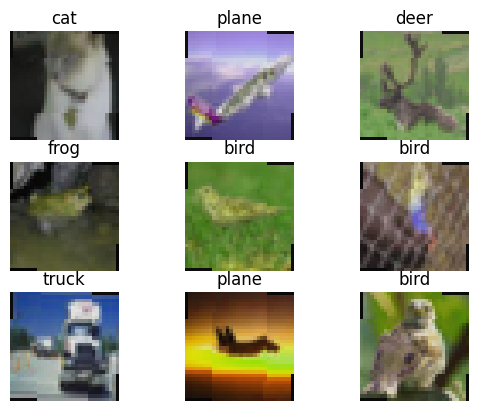

In [11]:
images, labels = next(iter(train_dataloader))
images = data_augmentation(images)
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  img = images[i]
  plt.imshow(img.permute(1, 2, 0))
  plt.title(classes[labels[i]])
  plt.axis("off")

### Neural Network

In [12]:
class NNmodel(nn.Module):
  def __init__(self):
    super().__init__()
    self.data_augmentation = data_augmentation
    self.normalize = normalize
    self.flatten = nn.Flatten()
    self.linear_relu = nn.Sequential(
        nn.Linear(3*32*32, 500),
        nn.ReLU(),
        nn.Linear(500, 500),
        nn.ReLU(),
        nn.Linear(500, 10)
    )
  def forward(self, x):
    x = self.data_augmentation(x)
    x = self.normalize(x)
    x = self.flatten(x)
    return self.linear_relu(x)


In [13]:
nn_model = NNmodel().to(device)
print(nn_model)

NNmodel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu): Sequential(
    (0): Linear(in_features=3072, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=10, bias=True)
  )
)


In [14]:
learning_rate = 1e-3
epochs = 20

# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(nn_model.parameters(), lr=learning_rate)

In [9]:
def train_loop(dataloader, model, loss_fn, optimizer):
  total_loss, correct = 0, 0
  model.train()
  for batch, (X, y) in enumerate(dataloader):
    optimizer.zero_grad()
    X, y = X.cuda(), y.cuda()
    pred = model(X)
    loss = loss_fn(pred, y)
    total_loss += loss.item()
    correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    loss.backward()
    optimizer.step()
    
    if batch%250 == 249:
      print(f"loss: {loss:.7f}  [{batch+1:5d}/{len(dataloader):5d}]")

  accuracy = correct/float(len(dataloader.dataset))
  avg_loss = total_loss/float(len(dataloader.dataset))
  print("---Train---")
  print(f"Accuracy: {accuracy}")
  print(f"Average loss: {avg_loss}")
  return avg_loss, accuracy

def val_loop(dataloader, model, loss_fn):
  total_loss, correct = 0, 0
  model.eval()
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.cuda(), y.cuda()
      pred = model(X)
      loss = loss_fn(pred, y)
      total_loss += loss.item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()
      
    accuracy = correct/float(len(dataloader.dataset))
    avg_loss = total_loss/float(len(dataloader.dataset))
    print("---Validation---")
    print(f"Accuracy: {accuracy}")
    print(f"Average loss: {avg_loss}")
  return avg_loss, accuracy



In [16]:
train_accuracy = []
val_accuracy = []
train_loss = []
val_loss = []
for i in range(epochs):
  print(f"Epoch {i+1}")
  train_loss_output, train_acc_output = train_loop(train_dataloader, nn_model, loss_fn, optimizer)
  val_loss_output, val_acc_output = val_loop(val_dataloader, nn_model, loss_fn)
  train_loss.append(train_loss_output)
  train_accuracy.append(train_acc_output)
  val_loss.append(val_loss_output)
  val_accuracy.append(val_acc_output)

Epoch 1
loss: 1.8627081  [  250/ 1250]
loss: 1.9064541  [  500/ 1250]
loss: 1.8024521  [  750/ 1250]
loss: 1.5767528  [ 1000/ 1250]
loss: 1.7069895  [ 1250/ 1250]
---Train---
Accuracy: 0.3454
Average loss: 0.05732042892277241
---Validation---
Accuracy: 0.4145
Average loss: 0.052268623983860014
Epoch 2
loss: 1.4451984  [  250/ 1250]
loss: 1.5035373  [  500/ 1250]
loss: 1.5956345  [  750/ 1250]
loss: 1.5186572  [ 1000/ 1250]
loss: 1.4890575  [ 1250/ 1250]
---Train---
Accuracy: 0.412475
Average loss: 0.05200794588625431
---Validation---
Accuracy: 0.417
Average loss: 0.051219493997097014
Epoch 3
loss: 1.2715628  [  250/ 1250]
loss: 1.5604687  [  500/ 1250]
loss: 1.3118662  [  750/ 1250]
loss: 1.4048597  [ 1000/ 1250]
loss: 1.5356671  [ 1250/ 1250]
---Train---
Accuracy: 0.44445
Average loss: 0.049707123728096485
---Validation---
Accuracy: 0.4327
Average loss: 0.050357754504680635
Epoch 4
loss: 1.7240614  [  250/ 1250]
loss: 1.4054409  [  500/ 1250]
loss: 1.4717460  [  750/ 1250]
loss: 1.410

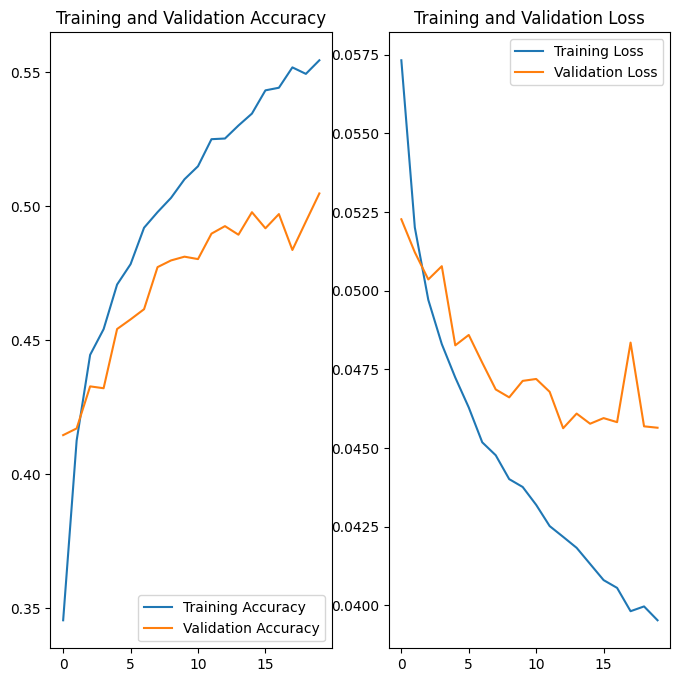

In [23]:
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [10]:
def test_loop(dataloader, model, loss_fn):
    total_loss, correct = 0, 0
    model.eval()

    for X, y in dataloader:
        X, y = X.cuda(), y.cuda()
        with torch.no_grad():
            pred = model(X)
            loss = loss_fn(pred, y)
            total_loss += loss.item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
    accuracy = correct/float(len(dataloader.dataset))

    print("---Test---")
    print(f"Accuracy: {accuracy}")
    print(f"Total loss: {total_loss}")

    return total_loss, accuracy

In [25]:
test_loop(test_dataloader, nn_model, loss_fn)

---Test---
Accuracy: 0.494
Total loss: 457.2591624259949


(457.2591624259949, 0.494)

In [26]:
images, labels = next(iter(test_dataloader))

outputs = nn_model(images.cuda())
preds = outputs.argmax(1)
print(preds)

tensor([3, 8, 8, 0, 4, 6, 2, 6, 4, 8, 0, 9, 5, 7, 9, 8, 5, 9, 8, 6, 4, 0, 0, 9,
        2, 2, 4, 4, 2, 6, 6, 4], device='cuda:0')


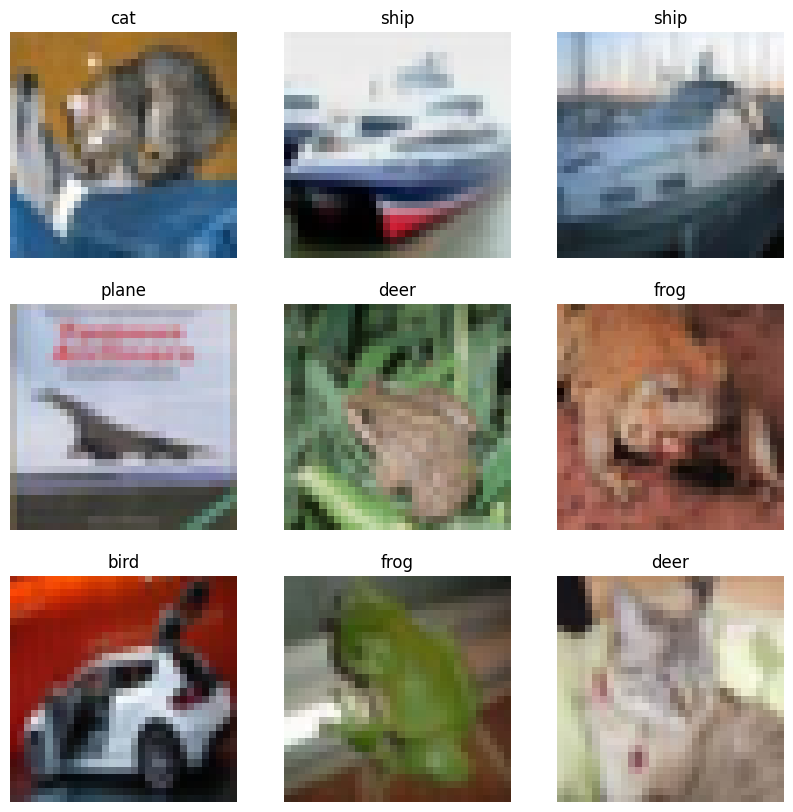

In [27]:
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  img = images[i]
  plt.imshow(img.permute(1, 2, 0))
  plt.title(classes[preds[i]])
  plt.axis("off")

In [33]:
#save model
PATH = "models/nn_model.pt"
torch.save(nn_model.state_dict(), PATH)

In [34]:
#free memory
import gc

nn_model = None
gc.collect()
with torch.no_grad():
    torch.cuda.empty_cache()

### CNN

In [35]:
class CNNmodel(nn.Module):
  def __init__(self):
    super().__init__()
    self.data_augmentation = data_augmentation
    self.normalize = normalize
    self.network = nn.Sequential(
      #3x32x32 -> 6x32x32
      nn.Conv2d(3, 6, 3, padding=1),
      nn.ReLU(),
      #6x32x32 -> 6x16x16
      nn.MaxPool2d(2, 2),
      #6x16x16 -> 12x16x16
      nn.Conv2d(6, 12, 3, padding=1),
      nn.ReLU(),
      #12x16x16 -> 12x8x8
      nn.MaxPool2d(2, 2),
      nn.Dropout(0.2),
      #Flatten all except batch
      #12x8x8 -> 768
      nn.Flatten(),
      nn.Linear(768, 150),
      nn.ReLU(),
      nn.Linear(150, 80),
      nn.ReLU(),
      nn.Linear(80, 10)
      )
  def forward(self, x):
    x = self.data_augmentation(x)
    x = self.normalize(x)
    return self.network(x)


In [36]:
cnn_model = CNNmodel().to(device)
print(cnn_model)

CNNmodel(
  (network): Sequential(
    (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout(p=0.2, inplace=False)
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Linear(in_features=768, out_features=150, bias=True)
    (9): ReLU()
    (10): Linear(in_features=150, out_features=80, bias=True)
    (11): ReLU()
    (12): Linear(in_features=80, out_features=10, bias=True)
  )
)


In [37]:
from torchsummary import summary
summary(cnn_model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 32, 32]             168
              ReLU-2            [-1, 6, 32, 32]               0
         MaxPool2d-3            [-1, 6, 16, 16]               0
            Conv2d-4           [-1, 12, 16, 16]             660
              ReLU-5           [-1, 12, 16, 16]               0
         MaxPool2d-6             [-1, 12, 8, 8]               0
           Dropout-7             [-1, 12, 8, 8]               0
           Flatten-8                  [-1, 768]               0
            Linear-9                  [-1, 150]         115,350
             ReLU-10                  [-1, 150]               0
           Linear-11                   [-1, 80]          12,080
             ReLU-12                   [-1, 80]               0
           Linear-13                   [-1, 10]             810
Total params: 129,068
Trainable params:

In [38]:
learning_rate = 1e-3
epochs = 20

# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(cnn_model.parameters(), lr=learning_rate)

In [39]:
train_accuracy = []
val_accuracy = []
train_loss = []
val_loss = []
for i in range(epochs):
  print(f"Epoch {i+1}")
  train_loss_output, train_acc_output = train_loop(train_dataloader, cnn_model, loss_fn, optimizer)
  val_loss_output, val_acc_output = val_loop(val_dataloader, cnn_model, loss_fn)
  train_loss.append(train_loss_output)
  train_accuracy.append(train_acc_output)
  val_loss.append(val_loss_output)
  val_accuracy.append(val_acc_output)

Epoch 1
loss: 1.8612241  [  250/ 1250]
loss: 1.6421168  [  500/ 1250]
loss: 2.5090778  [  750/ 1250]
loss: 1.8293355  [ 1000/ 1250]
loss: 1.6134325  [ 1250/ 1250]
---Train---
Accuracy: 0.3649
Average loss: 0.05460171538889408
---Validation---
Accuracy: 0.4429
Average loss: 0.04888925951719284
Epoch 2
loss: 1.4187783  [  250/ 1250]
loss: 1.6483483  [  500/ 1250]
loss: 1.5288944  [  750/ 1250]
loss: 1.3961406  [ 1000/ 1250]
loss: 1.2241772  [ 1250/ 1250]
---Train---
Accuracy: 0.46975
Average loss: 0.0462204473182559
---Validation---
Accuracy: 0.5209
Average loss: 0.04241399820446968
Epoch 3
loss: 1.4289345  [  250/ 1250]
loss: 1.5069791  [  500/ 1250]
loss: 1.1487534  [  750/ 1250]
loss: 1.3202925  [ 1000/ 1250]
loss: 1.5308123  [ 1250/ 1250]
---Train---
Accuracy: 0.51945
Average loss: 0.04270996180176735
---Validation---
Accuracy: 0.547
Average loss: 0.03979282696247101
Epoch 4
loss: 1.2389002  [  250/ 1250]
loss: 1.0822047  [  500/ 1250]
loss: 1.0405908  [  750/ 1250]
loss: 1.4355139  

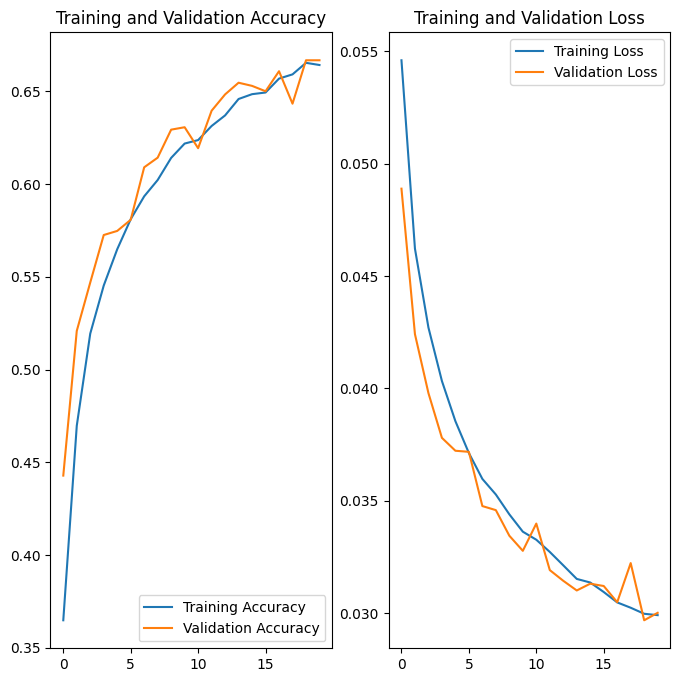

In [41]:
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [42]:
#train for 10 more epochs

for i in range(10):
  print(f"Epoch {i+1}")
  train_loss_output, train_acc_output = train_loop(train_dataloader, cnn_model, loss_fn, optimizer)
  val_loss_output, val_acc_output = val_loop(val_dataloader, cnn_model, loss_fn)
  train_loss.append(train_loss_output)
  train_accuracy.append(train_acc_output)
  val_loss.append(val_loss_output)
  val_accuracy.append(val_acc_output)

Epoch 1
loss: 0.7558135  [  250/ 1250]
loss: 0.7942274  [  500/ 1250]
loss: 0.7708938  [  750/ 1250]
loss: 1.0172508  [ 1000/ 1250]
loss: 0.6984339  [ 1250/ 1250]
---Train---
Accuracy: 0.667525
Average loss: 0.029460897593200207
---Validation---
Accuracy: 0.6671
Average loss: 0.029862167608737944
Epoch 2
loss: 1.0725608  [  250/ 1250]
loss: 1.0807101  [  500/ 1250]
loss: 1.0364377  [  750/ 1250]
loss: 1.2268901  [ 1000/ 1250]
loss: 0.9677131  [ 1250/ 1250]
---Train---
Accuracy: 0.6684
Average loss: 0.029497430870682
---Validation---
Accuracy: 0.6598
Average loss: 0.030264214956760408
Epoch 3
loss: 1.0593841  [  250/ 1250]
loss: 0.8572756  [  500/ 1250]
loss: 0.8399587  [  750/ 1250]
loss: 1.1223204  [ 1000/ 1250]
loss: 0.7673449  [ 1250/ 1250]
---Train---
Accuracy: 0.674025
Average loss: 0.02920105527341366
---Validation---
Accuracy: 0.6535
Average loss: 0.031273632687330244
Epoch 4
loss: 0.6856195  [  250/ 1250]
loss: 0.9339724  [  500/ 1250]
loss: 0.9949580  [  750/ 1250]
loss: 0.806

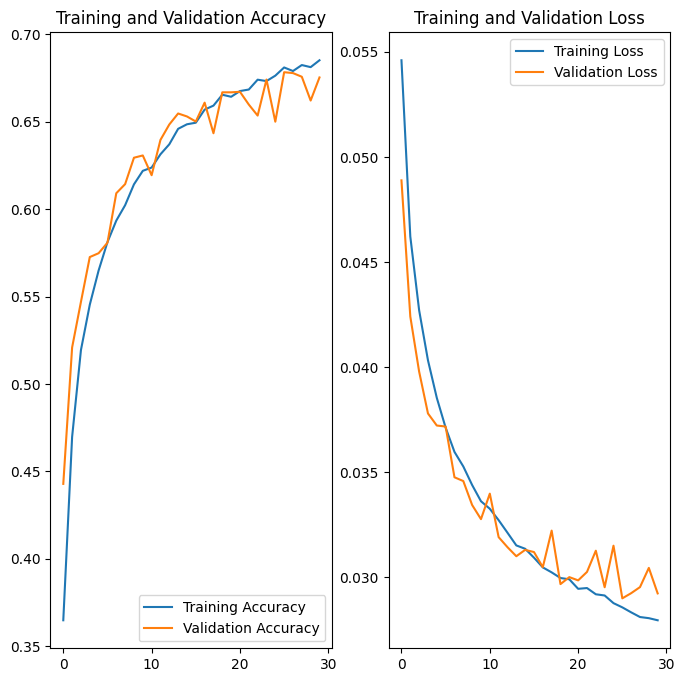

In [43]:
epochs_range = range(30)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [46]:
#train for 10 more epochs

for i in range(10):
  print(f"Epoch {i+1}")
  train_loss_output, train_acc_output = train_loop(train_dataloader, cnn_model, loss_fn, optimizer)
  val_loss_output, val_acc_output = val_loop(val_dataloader, cnn_model, loss_fn)
  train_loss.append(train_loss_output)
  train_accuracy.append(train_acc_output)
  val_loss.append(val_loss_output)
  val_accuracy.append(val_acc_output)

Epoch 1
loss: 0.8397315  [  250/ 1250]
loss: 0.9038233  [  500/ 1250]
loss: 0.5460123  [  750/ 1250]
loss: 0.6657395  [ 1000/ 1250]
loss: 0.6473798  [ 1250/ 1250]
---Train---
Accuracy: 0.685475
Average loss: 0.027814468562602997
---Validation---
Accuracy: 0.6525
Average loss: 0.031072512936592103
Epoch 2
loss: 0.6500884  [  250/ 1250]
loss: 0.8446097  [  500/ 1250]
loss: 1.2090069  [  750/ 1250]
loss: 1.2064826  [ 1000/ 1250]
loss: 0.9016216  [ 1250/ 1250]
---Train---
Accuracy: 0.6871
Average loss: 0.027724251626431943
---Validation---
Accuracy: 0.6797
Average loss: 0.029212321293354035
Epoch 3
loss: 0.8510457  [  250/ 1250]
loss: 0.8139725  [  500/ 1250]
loss: 0.9615604  [  750/ 1250]
loss: 0.8339864  [ 1000/ 1250]
loss: 1.0457705  [ 1250/ 1250]
---Train---
Accuracy: 0.688475
Average loss: 0.027726239354163407
---Validation---
Accuracy: 0.6722
Average loss: 0.029013772296905518
Epoch 4
loss: 0.6536623  [  250/ 1250]
loss: 0.8292706  [  500/ 1250]
loss: 0.9466740  [  750/ 1250]
loss: 0

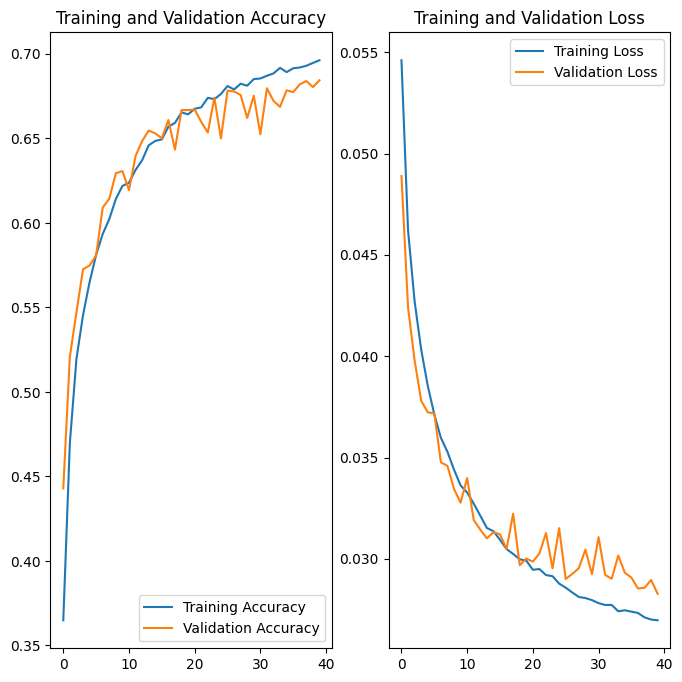

In [47]:
epochs_range = range(40)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [48]:
test_loop(test_dataloader, cnn_model, loss_fn)

---Test---
Accuracy: 0.6851
Total loss: 285.5961849987507


(285.5961849987507, 0.6851)

In [49]:
images, labels = next(iter(test_dataloader))

outputs = cnn_model(images.cuda())
preds = outputs.argmax(1)
print(preds)

tensor([3, 8, 8, 0, 6, 6, 0, 6, 3, 1, 0, 9, 3, 7, 9, 8, 5, 3, 8, 6, 1, 0, 0, 9,
        4, 3, 4, 0, 9, 6, 6, 2], device='cuda:0')


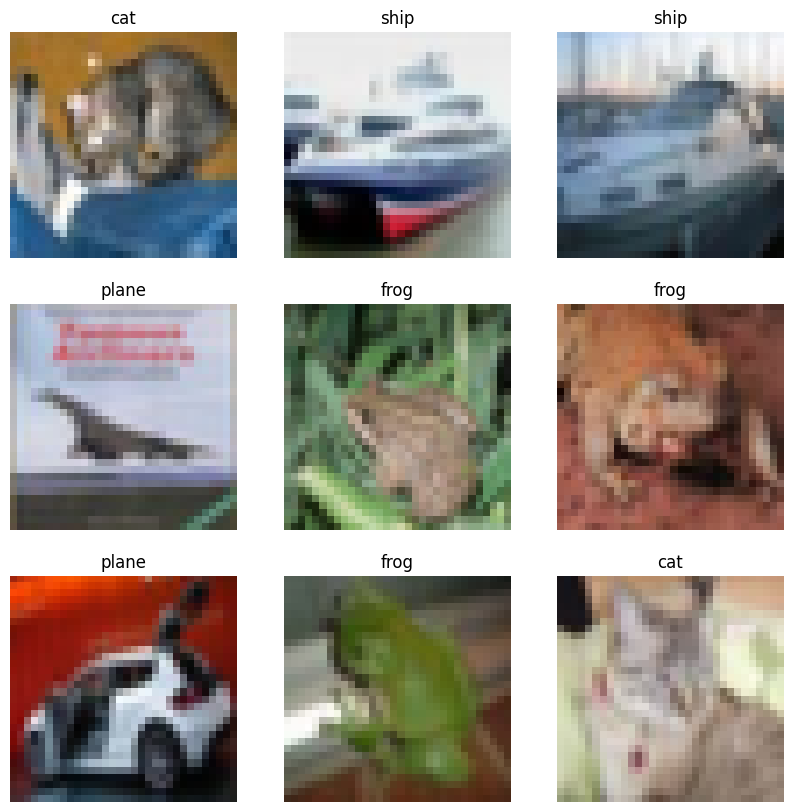

In [50]:
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  img = images[i]
  plt.imshow(img.permute(1, 2, 0))
  plt.title(classes[preds[i]])
  plt.axis("off")

In [51]:
#save model
PATH = "models/cnn_model.pt"
torch.save(cnn_model.state_dict(), PATH)

In [52]:
#free memory
import gc

cnn_model = None
gc.collect()
with torch.no_grad():
    torch.cuda.empty_cache()

## Finetuning pretrained models

In [11]:
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights

weights = EfficientNet_V2_S_Weights.DEFAULT
efficientnet_v2_model = efficientnet_v2_s(weights=weights).to(device)

In [14]:
print(efficientnet_v2_model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [12]:
preprocess = weights.transforms()

In [20]:
images, labels = next(iter(test_dataloader))
batch = preprocess(images)

In [17]:
print(batch.size())

torch.Size([32, 3, 384, 384])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


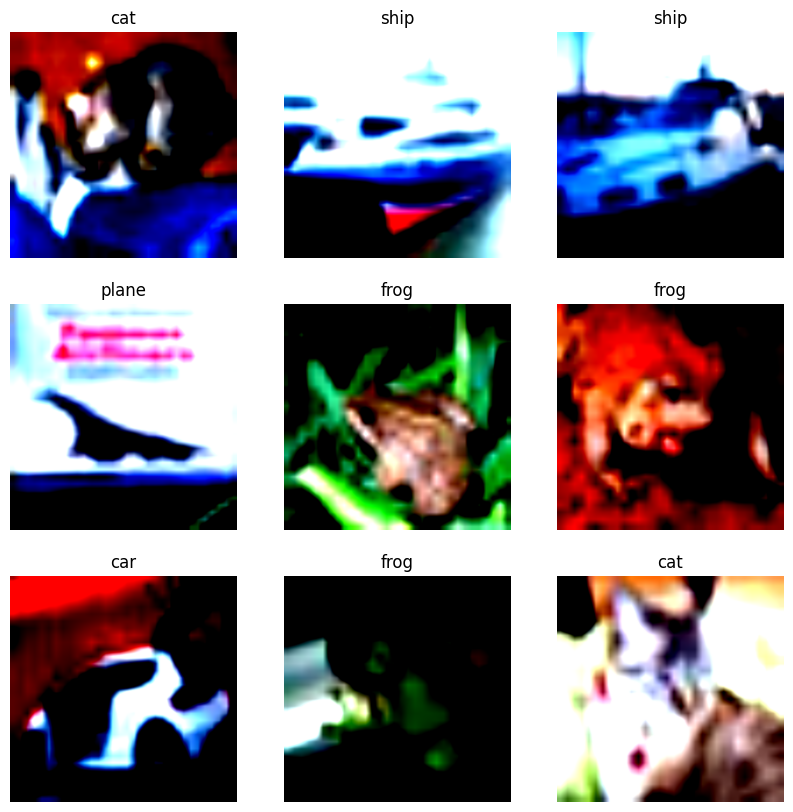

In [18]:
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  img = batch[i]
  plt.imshow(img.permute(1, 2, 0))
  plt.title(classes[labels[i]])
  plt.axis("off")

In [13]:
#freeze network except for final layer
for param in efficientnet_v2_model.parameters():
    param.requires_grad = False

In [14]:
#change final layer
efficientnet_v2_model.classifier[1] = nn.Linear(efficientnet_v2_model.classifier[1].in_features, len(classes)).to(device)

In [15]:
efficientnet_v2_model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=10, bias=True)
)

In [16]:
class effnetmodel(nn.Module):
  def __init__(self):
    super().__init__()
    self.data_augmentation = data_augmentation
    self.preprocess = preprocess
    self.effnet = efficientnet_v2_model
  def forward(self, x):
    x = self.data_augmentation(x)
    x = self.preprocess(x)
    return self.effnet(x)


In [17]:
effnet_model = effnetmodel().to(device)
print(effnet_model)

effnetmodel(
  (preprocess): ImageClassification(
      crop_size=[384]
      resize_size=[384]
      mean=[0.485, 0.456, 0.406]
      std=[0.229, 0.224, 0.225]
      interpolation=InterpolationMode.BILINEAR
  )
  (effnet): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): FusedMBConv(


In [18]:
from torchsummary import summary
summary(effnet_model, (3, 32, 32))

c:\Users\waiho\Documents\Python_venv\AI_ML_env\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
ImageClassification-1          [-1, 3, 384, 384]               0
            Conv2d-2         [-1, 24, 192, 192]             648
       BatchNorm2d-3         [-1, 24, 192, 192]              48
              SiLU-4         [-1, 24, 192, 192]               0
            Conv2d-5         [-1, 24, 192, 192]           5,184
       BatchNorm2d-6         [-1, 24, 192, 192]              48
              SiLU-7         [-1, 24, 192, 192]               0
   StochasticDepth-8         [-1, 24, 192, 192]               0
       FusedMBConv-9         [-1, 24, 192, 192]               0
           Conv2d-10         [-1, 24, 192, 192]           5,184
      BatchNorm2d-11         [-1, 24, 192, 192]              48
             SiLU-12         [-1, 24, 192, 192]               0
  StochasticDepth-13         [-1, 24, 192, 192]               0
      FusedMBConv-14         [-1, 24, 

In [21]:
outputs = effnet_model(batch.cuda())
preds = outputs.argmax(1)
print(preds)

tensor([5, 2, 9, 9, 2, 3, 7, 8, 8, 8, 0, 3, 2, 1, 1, 2, 0, 9, 6, 2, 9, 4, 2, 3,
        9, 9, 8, 0, 8, 5, 2, 8], device='cuda:0')


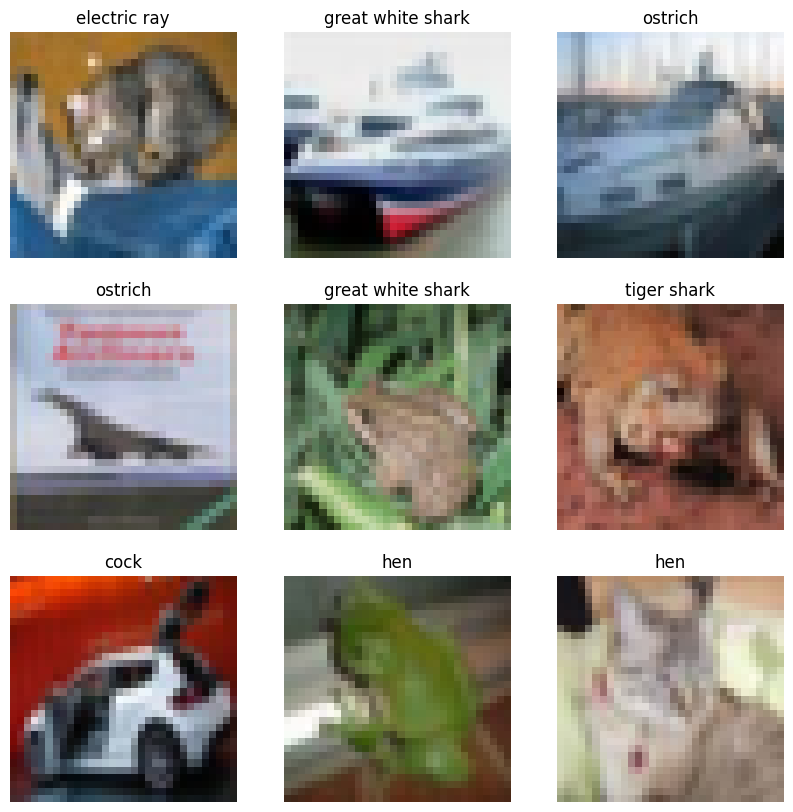

In [22]:
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  img = images[i]
  plt.imshow(img.permute(1, 2, 0))
  plt.title(weights.meta["categories"][preds[i]])
  plt.axis("off")

In [23]:
learning_rate = 1e-3
epochs = 20

# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(effnet_model.parameters(), lr=learning_rate)

In [24]:
train_accuracy = []
val_accuracy = []
train_loss = []
val_loss = []
for i in range(epochs):
  print(f"Epoch {i+1}")
  train_loss_output, train_acc_output = train_loop(train_dataloader, effnet_model, loss_fn, optimizer)
  val_loss_output, val_acc_output = val_loop(val_dataloader, effnet_model, loss_fn)
  train_loss.append(train_loss_output)
  train_accuracy.append(train_acc_output)
  val_loss.append(val_loss_output)
  val_accuracy.append(val_acc_output)

Epoch 1
loss: 1.2690392  [  250/ 1250]
loss: 1.6862520  [  500/ 1250]
loss: 1.2207589  [  750/ 1250]
loss: 1.4194609  [ 1000/ 1250]
loss: 0.9788046  [ 1250/ 1250]
---Train---
Accuracy: 0.540125
Average loss: 0.04243675632625818
---Validation---
Accuracy: 0.6014
Average loss: 0.03567074192762375
Epoch 2
loss: 0.9798301  [  250/ 1250]
loss: 1.1373235  [  500/ 1250]
loss: 1.2271979  [  750/ 1250]
loss: 1.2488958  [ 1000/ 1250]
loss: 0.7219571  [ 1250/ 1250]
---Train---
Accuracy: 0.580725
Average loss: 0.0373571569904685
---Validation---
Accuracy: 0.6167
Average loss: 0.03457744327187538
Epoch 3
loss: 1.1212678  [  250/ 1250]
loss: 0.6443895  [  500/ 1250]
loss: 1.1160002  [  750/ 1250]
loss: 1.3963104  [ 1000/ 1250]
loss: 1.2286564  [ 1250/ 1250]
---Train---
Accuracy: 0.591
Average loss: 0.036426936896145345
---Validation---
Accuracy: 0.6304
Average loss: 0.1551734576970339
Epoch 4
loss: 1.2240369  [  250/ 1250]
loss: 1.2357910  [  500/ 1250]
loss: 1.1664593  [  750/ 1250]
loss: 1.0508442

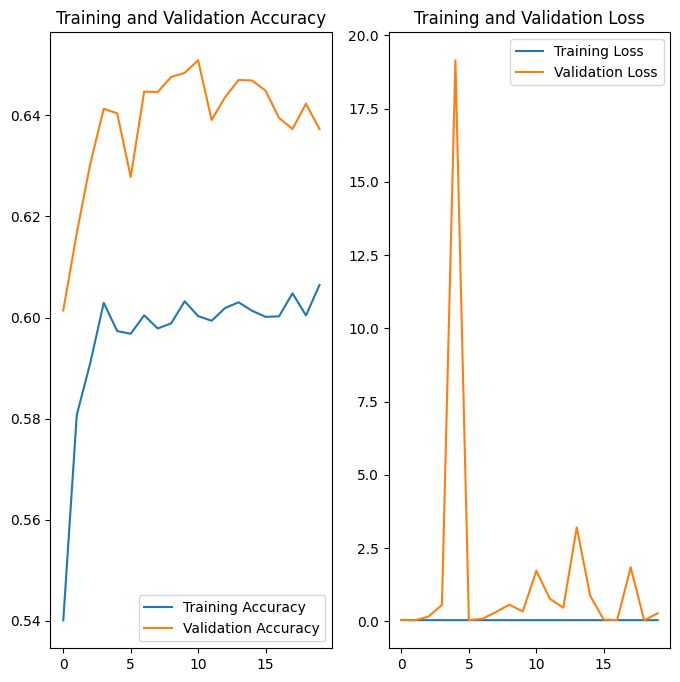

In [25]:
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [26]:
test_loop(test_dataloader, effnet_model, loss_fn)

---Test---
Accuracy: 0.6421
Total loss: 10391.042515158653


(10391.042515158653, 0.6421)

In [27]:
images, labels = next(iter(test_dataloader))

outputs = effnet_model(images.cuda())
preds = outputs.argmax(1)
print(preds)

tensor([3, 1, 8, 0, 6, 6, 1, 6, 3, 9, 0, 9, 7, 1, 9, 8, 5, 6, 0, 6, 9, 0, 4, 9,
        4, 2, 3, 7, 9, 6, 6, 5], device='cuda:0')


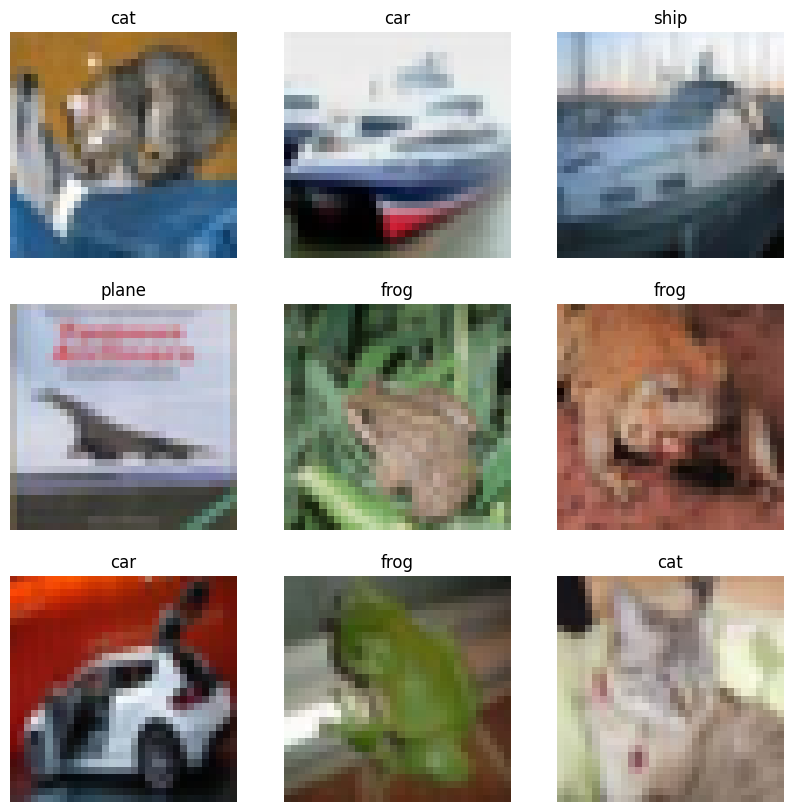

In [28]:
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  img = images[i]
  plt.imshow(img.permute(1, 2, 0))
  plt.title(classes[preds[i]])
  plt.axis("off")

In [29]:
#save model
PATH = "models/efficientnet_v2_model.pt"
torch.save(effnet_model.state_dict(), PATH)

### Without freezing layers

In [11]:
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights

weights = MobileNet_V3_Small_Weights.DEFAULT
mobilenet_v3_model_full = mobilenet_v3_small(weights=weights).to(device)

In [12]:
preprocess = weights.transforms()

In [13]:
print(mobilenet_v3_model_full.classifier)

Sequential(
  (0): Linear(in_features=576, out_features=1024, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=1024, out_features=1000, bias=True)
)


In [14]:
#change final layer
mobilenet_v3_model_full.classifier[3] = nn.Linear(mobilenet_v3_model_full.classifier[3].in_features, len(classes)).to(device)

In [15]:
print(mobilenet_v3_model_full.classifier)

Sequential(
  (0): Linear(in_features=576, out_features=1024, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=1024, out_features=10, bias=True)
)


In [16]:
class mobnetmodelfull(nn.Module):
  def __init__(self):
    super().__init__()
    self.data_augmentation = data_augmentation
    self.preprocess = preprocess
    self.mobnet = mobilenet_v3_model_full
  def forward(self, x):
    x = self.data_augmentation(x)
    x = self.preprocess(x)
    return self.mobnet(x)


In [17]:
mobnet_model_full = mobnetmodelfull().to(device)
print(mobnet_model_full)

mobnetmodelfull(
  (preprocess): ImageClassification(
      crop_size=[224]
      resize_size=[256]
      mean=[0.485, 0.456, 0.406]
      std=[0.229, 0.224, 0.225]
      interpolation=InterpolationMode.BILINEAR
  )
  (mobnet): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(16, 8, kernel_size

In [18]:
from torchsummary import summary
summary(mobnet_model_full, (3, 32, 32))

c:\Users\waiho\Documents\Python_venv\AI_ML_env\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
ImageClassification-1          [-1, 3, 224, 224]               0
            Conv2d-2         [-1, 16, 112, 112]             432
       BatchNorm2d-3         [-1, 16, 112, 112]              32
         Hardswish-4         [-1, 16, 112, 112]               0
            Conv2d-5           [-1, 16, 56, 56]             144
       BatchNorm2d-6           [-1, 16, 56, 56]              32
              ReLU-7           [-1, 16, 56, 56]               0
 AdaptiveAvgPool2d-8             [-1, 16, 1, 1]               0
            Conv2d-9              [-1, 8, 1, 1]             136
             ReLU-10              [-1, 8, 1, 1]               0
           Conv2d-11             [-1, 16, 1, 1]             144
      Hardsigmoid-12             [-1, 16, 1, 1]               0
SqueezeExcitation-13           [-1, 16, 56, 56]               0
           Conv2d-14           [-1, 16

In [19]:
learning_rate = 1e-3
epochs = 10

# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(mobnet_model_full.parameters(), lr=learning_rate)

In [20]:
train_accuracy = []
val_accuracy = []
train_loss = []
val_loss = []
for i in range(epochs):
  print(f"Epoch {i+1}")
  train_loss_output, train_acc_output = train_loop(train_dataloader, mobnet_model_full, loss_fn, optimizer)
  val_loss_output, val_acc_output = val_loop(val_dataloader, mobnet_model_full, loss_fn)
  train_loss.append(train_loss_output)
  train_accuracy.append(train_acc_output)
  val_loss.append(val_loss_output)
  val_accuracy.append(val_acc_output)

Epoch 1
loss: 0.4442215  [  250/ 1250]
loss: 0.5689353  [  500/ 1250]
loss: 0.3988471  [  750/ 1250]
loss: 0.4449134  [ 1000/ 1250]
loss: 0.2491102  [ 1250/ 1250]
---Train---
Accuracy: 0.816875
Average loss: 0.01676131794638932
---Validation---
Accuracy: 0.7729
Average loss: 0.02098507016301155
Epoch 2
loss: 0.4668831  [  250/ 1250]
loss: 0.3827341  [  500/ 1250]
loss: 0.2939893  [  750/ 1250]
loss: 0.0762305  [ 1000/ 1250]
loss: 0.3673722  [ 1250/ 1250]
---Train---
Accuracy: 0.88115
Average loss: 0.0109697798977606
---Validation---
Accuracy: 0.7482
Average loss: 0.023573468758165836
Epoch 3
loss: 0.4687812  [  250/ 1250]
loss: 0.1731790  [  500/ 1250]
loss: 0.1548779  [  750/ 1250]
loss: 0.3642653  [ 1000/ 1250]
loss: 0.2006940  [ 1250/ 1250]
---Train---
Accuracy: 0.901325
Average loss: 0.009106132993474602
---Validation---
Accuracy: 0.8748
Average loss: 0.011694527146685868
Epoch 4
loss: 0.4443972  [  250/ 1250]
loss: 0.1308683  [  500/ 1250]
loss: 0.1826720  [  750/ 1250]
loss: 0.09

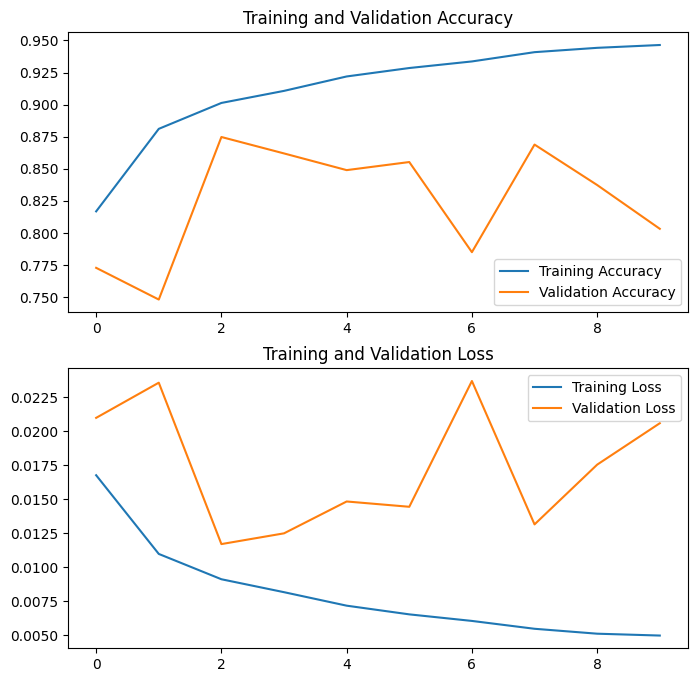

In [23]:
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
test_loop(test_dataloader, mobnet_model_full, loss_fn)

c:\Users\waiho\Documents\Python_venv\AI_ML_env\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


---Test---
Accuracy: 0.8146
Total loss: 196.7889033742249


(196.7889033742249, 0.8146)

In [25]:
images, labels = next(iter(test_dataloader))

outputs = mobnet_model_full(images.cuda())
preds = outputs.argmax(1)
print(preds)

tensor([3, 8, 1, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 0, 9,
        4, 2, 0, 0, 9, 6, 6, 5], device='cuda:0')


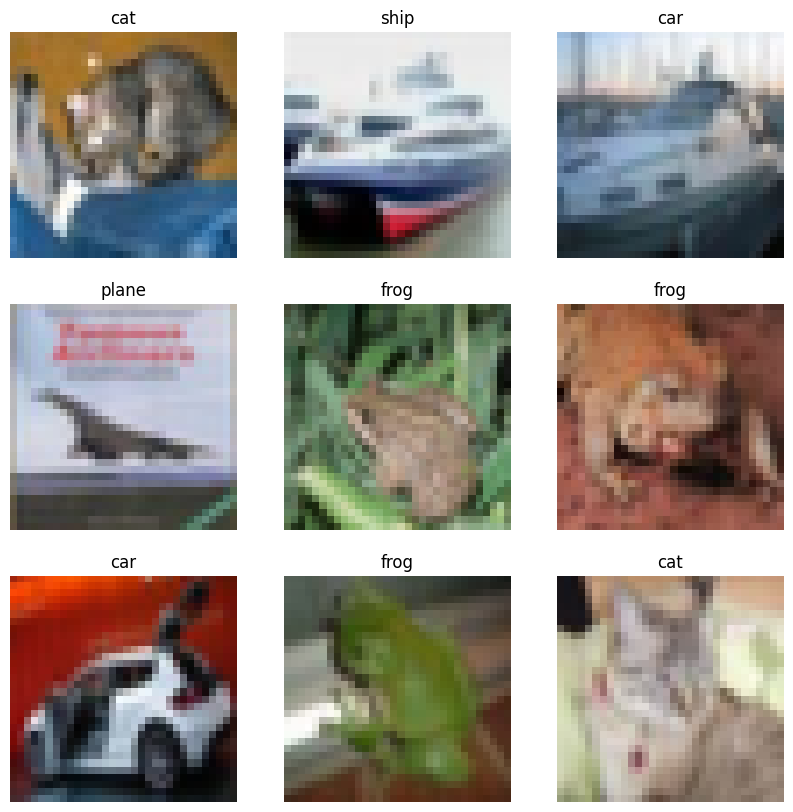

In [26]:
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  img = images[i]
  plt.imshow(img.permute(1, 2, 0))
  plt.title(classes[preds[i]])
  plt.axis("off")

In [ ]:
#save model
PATH = "models/mobilenet_v3_model_full.pt"
torch.save(mobnet_model_full.state_dict(), PATH)